In [1]:
from typing import List
from typing import Optional
from typing import Tuple
import copy


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision.models as models


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
    ):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.class_nb = class_nb
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            str(self.class_nb),
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)
    
    def get_coords(self) -> torch.Tensor:
        return torch.tensor([self.x_min, self.y_min, self.x_max, self.y_max]).to(DEVICE)

class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
           class_nb=class_nb,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

In [44]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)

    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit = digits[current_digit_index]
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=classes[current_digit_index],
        ):
            attempts_done += 1
    return new_canvas

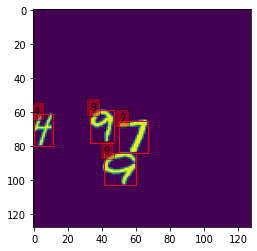

In [45]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

In [46]:
# TEST_CANVAS_SIZE = 256
TEST_CANVAS_SIZE = 64


TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TRAIN_CANVAS_SIZE = 256

TRAIN_CANVAS = [
    get_random_canvas() for _ in range(TRAIN_CANVAS_SIZE)
]

Width: min 12, max 19, mean 18.846713718570797
Height: min 3, max 19, mean 13.824437582708425


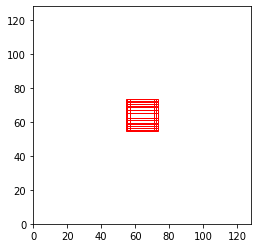

[[19.         16.69742198]
 [19.         11.36332767]
 [19.          3.40116279]
 [19.         14.69724771]
 [18.94468085 18.8822695 ]
 [19.          5.73421927]
 [14.14285714 19.        ]
 [19.          9.10948905]
 [19.         13.        ]
 [16.86363636 19.        ]]


In [47]:
# Anchor size analysis
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

ANCHOR_SET_SIZE = 1000

anchor_test_canvas = [get_random_canvas(digits=TEST_DIGITS, classes=TEST_CLASSES) for _ in range(ANCHOR_SET_SIZE)]

boxes = list(itertools.chain.from_iterable([c.boxes for c in anchor_test_canvas]))
S = np.asarray(list(map(list, zip(*(list(map(lambda b: (b.x_diff, b.y_diff), boxes))))))).T

x = S[:, 0]
y = S[:, 1]
print("Width: min {}, max {}, mean {}".format(min(x), max(x), np.mean(x)))
print("Height: min {}, max {}, mean {}".format(min(y), max(y), np.mean(y)))

n_clusters = 10 # TODO calculate silhouettes
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(S)
anchors = clusterer.cluster_centers_
ANCHOR_SIZES = anchors.copy()

anchors = np.rint(anchors)
fig, ax = plt.subplots()
for i in range(n_clusters):
    ax.add_patch(patches.Rectangle((64 - anchors[i, 0]/2, 64 - anchors[i, 1]/2), anchors[i, 0], anchors[i, 1], linewidth=1, edgecolor='r', facecolor=None, fill=None))
ax.set_aspect(1.0)
plt.axis([0,128,0,128])
plt.show()

print(ANCHOR_SIZES)

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.classification_output = classification_output
        self.box_regression_output = box_regression_output

# 1: resnet18[1:-4]: slabo
# 2: vgg-11
class DigitDetectionModel(torch.nn.Module):
    def __init__(
        self,
        backbone : torch.nn.Module,
        anchor_sizes : int
    ):
        super().__init__()
        self.fc1 = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1)
        features = list(backbone.children())
        self.backbone = nn.Sequential(
            *features[:-2]
        )

        for p in self.backbone: #TODO is this required?
            p.requires_grad = False

        self.anchors : List[MnistBox] = []
        k = 3
        for m in range(0, 128//2**k):
            x_c = (m + 1/2) * 2**k
            for n in range(0, 128//2**k):
                y_c = (n + 1/2) * 2**k
                for [x, y] in anchor_sizes:
                    self.anchors.append(MnistBox(x_c - x/2, y_c - y/2, x_c + x/2, y_c + y/2))

        self.classificationHead = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 10 * len(anchor_sizes), kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        self.boxRegressionHead = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 4 * len(anchor_sizes), kernel_size=3, padding=1)
        )

    # def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
    def forward(self, x: MnistCanvas) -> torch.Tensor:
        # Note that this is defined for a single MnistCanvas
        
        in_tensor = x.get_torch_tensor()
#         print(in_tensor.shape)
        scaled = F.interpolate(in_tensor, (512,512))
#         print(scaled.shape)
        fitted = self.fc1(scaled)
#         print(fitted.shape)
        output = self.backbone(fitted)
        classification_output = torch.reshape(self.classificationHead(output), (len(self.anchors), 10))
        box_regression_output = torch.reshape(self.boxRegressionHead(output), (len(self.anchors), 4))


        return DigitDetectionModelOutput(self.anchors, classification_output, box_regression_output)

In [51]:
import torchvision.models as models

backbone = models.resnet18(pretrained=True).to(DEVICE)
model = DigitDetectionModel(backbone, ANCHOR_SIZES).to(DEVICE)
# print(model.parameters)
model.forward(get_random_canvas())

In [52]:
from torchvision.ops import nms
from operator import itemgetter, add 


class DigitDetectionModelTarget:

    def __init__(
        self,
        classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.classification_target = classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.5,
        nb_of_classes: int = 10,
    ) -> DigitDetectionModelTarget:
        classification_target = torch.zeros(len(anchors),nb_of_classes).to(DEVICE)
        box_regression_target = torch.zeros(len(anchors),4).to(DEVICE)
        matched_anchors = []
#         scores = torch.zeros(len(anchors)).to(DEVICE)

        gt_boxes = canvas.boxes
        for i, anchor in enumerate(anchors):
            gt_best = None
            gt_best_iou = .0
            for gt_box in gt_boxes:
                iou = anchor.iou_with(gt_box)
                if iou > iou_threshold and (iou > gt_best_iou or gt_best == None):
                    gt_best = gt_box
                    gt_best_iou = iou
            
            if gt_best != None:
                box_regression_target[i][0] = gt_best.x_min - anchor.x_min 
                box_regression_target[i][1] = gt_best.y_min - anchor.y_min 
                box_regression_target[i][2] = gt_best.x_max - anchor.x_max 
                box_regression_target[i][3] = gt_best.y_max - anchor.y_max

                classification_target[i][gt_best.class_nb] = 1
                matched_anchors.append(i)  
#                 scores[i] = gt_best_iou
               
        # TODO do poprawy
        
#         indices = nms(box_regression_target[matched_anchors], scores[matched_anchors], .2)
#         matched_anchors = [*itemgetter(*indices)(matched_anchors)]
        
        return DigitDetectionModelTarget(classification_target, box_regression_target, matched_anchors)
                        

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        scores, class_nbs = torch.max(model_output.classification_output, dim=1)
#         nonzeros = torch.nonzero(scores >= .1, as_tuple=True)
#         scores, class_nbs, = scores[nonzeros], class_nbs[nonzeros]
        
        # np.array(model_output.anchors)[nonzeros[0].cpu().numpy().astype(int)]
        coords = torch.stack([anchor.get_coords() + offsets for anchor, offsets in zip(model_output.anchors, model_output.box_regression_output)])
        indices = nms(coords, scores, .2) # TODO iou threshold

        return [MnistBox(*coord, class_nb.item()) for coord, class_nb in zip(coords[indices], class_nbs[indices])]

In [53]:
import torch
import torchvision 
from torchvision.ops import sigmoid_focal_loss

class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]: 
        indices = model_target.matched_anchors
        if not indices:
            return None
            
        return F.smooth_l1_loss(model_output.box_regression_output[indices], model_target.box_regression_target[indices])\
            + sigmoid_focal_loss(model_output.classification_output[indices], model_target.classification_target[indices], reduction='mean')


class DigitAccuracy:

    def compute_metric(
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ) -> int:
        if len(predicted_boxes) != len(canvas.boxes):
            return 0

        for canvas_box in canvas.boxes:
            match = False
            for predicted_box in predicted_boxes: # TODO pop?
                if canvas_box.class_nb == predicted_box.class_nb and canvas_box.iou_with(predicted_box) > 0.5:
                    match = True
                    break
            
            if not match:
                return 0

        return 1          

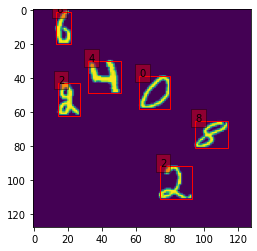

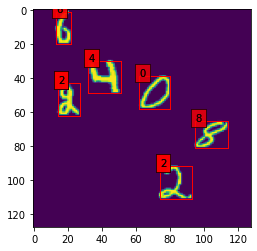

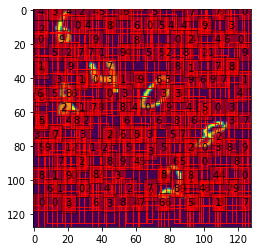

Correct:  0


tensor([0, 2, 4, 6, 8], device='cuda:0')

In [54]:
from operator import itemgetter, add 

canvas = get_random_canvas()
canvas.plot()

backbone = models.resnet18(pretrained=True).to(DEVICE)
model = DigitDetectionModel(backbone, ANCHOR_SIZES).to(DEVICE)

decoder = TargetDecoder()
targets = decoder.get_targets(canvas, model.anchors)
preds = decoder.get_predictions(model(canvas))
target_bxs = [MnistBox(*(anchor.get_coords() + offsets), class_nb.item()) for anchor, offsets, class_nb in zip(itemgetter(*targets.matched_anchors)(model.anchors), targets.box_regression_target[targets.matched_anchors], torch.max(targets.classification_target, dim=1)[1][targets.matched_anchors])]
canvas.plot(target_bxs)
canvas.plot(preds)
correct = DigitAccuracy().compute_metric(preds, canvas)
print("Correct: ", correct)
torch.unique(torch.argmax(targets.classification_target[targets.matched_anchors], dim=1))

In [57]:
import torch.optim as optim
import random as random

retina_loss = RetinaLoss()
digit_accuracy = DigitAccuracy()
target_decoder = TargetDecoder()

class EarlyStopping():
    def __init__(self, patience=5, min_delta=.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.stop = False
        
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss > self.min_delta:
            self.best_loss = loss
        elif self.best_loss - loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

def train(model, train_data, optimizer):
    model.train()
    train_loss = 0
    train_correct = 0
    matched = []
    mismatched = []
    

    for data in train_data:
        optimizer.zero_grad()
        output = model(data)
        target = target_decoder.get_targets(data, output.anchors)
        loss = retina_loss.compute_loss(output, target)
        train_loss += loss.item()
        preds = target_decoder.get_predictions(output)
        correct = digit_accuracy.compute_metric(preds, data)
        train_correct += correct
        if loss:
            loss.backward()
        optimizer.step()
        
#         if random.random() < 0.01:
#             lst = matched if correct else mismatched
#             lst.append((canvas, preds))
        

    train_loss /= len(train_data)
    train_accuracy = 100. * train_correct / len(train_data)

    return train_loss, train_accuracy, matched, mismatched

def test(model, test_data):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data in test_data:
            output = model(data)
            target = target_decoder.get_targets(data, output.anchors)
            test_loss += retina_loss.compute_loss(output, target)
            preds = target_decoder.get_predictions(output)
            correct += digit_accuracy.compute_metric(preds, data)

    test_loss /= len(test_data)
    test_accuracy = 100. * correct / len(test_data)

    return test_loss, test_accuracy

def prep_diagram(train_loss, train_accuracy, test_loss, test_accuracy):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    l1, = ax1.plot(train_loss, color='b', label="Train")
#     l2, = ax1.plot(test_loss, color='r', label='Test')
    ax1.set_title('Losses')
    ax2.plot(train_accuracy, color='b', label="Train")
#     ax2.plot(test_accuracy, color='r', label='Test')
    ax2.set_title('Accuracies')
    plt.legend([l1, l2], ["Train", "Test"])

    plt.show()

def train_loop(model, train_data, test_data, optimizer, epochs, early_stopping=None):
    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []
    
    for epoch in range(1, epochs + 1):
        print("\nEpoch: {}/{}\n".format(epoch, epochs))
        train_loss_epoch, train_accuracy_epoch, matched, mismatched = train(model, train_data, optimizer)
#         test_loss_epoch, test_accuracy_epoch = test(model, test_data)
        
        train_loss.append(train_loss_epoch)
        train_accuracy.append(train_accuracy_epoch)
        
        print("Matched:")
        for m in matched[:5]:
            m[0].plot(m[1])
            
        print("Mismatched:")
        for m in mismatched[:5]:
            m[0].plot(m[1])
        
#         test_loss.append(test_loss_epoch)
#         test_accuracy.append(test_accuracy_epoch)
        
        print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(train_loss_epoch, train_accuracy_epoch))
#         print('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss_epoch, test_accuracy_epoch))
        
        if not early_stopping == None:
            early_stopping(train_loss_epoch)
            if early_stopping.stop:
                print("Early stopped.")
                break
                
        
                
    prep_diagram(train_loss, train_accuracy, test_loss, test_accuracy)

In [ ]:
backbone = models.resnet18(pretrained=True).to(DEVICE)
model = DigitDetectionModel(backbone, ANCHOR_SIZES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=0.00004)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, TRAIN_CANVAS, TEST_CANVAS, optimizer, epochs, early_stopping)


Epoch: 1/40

